# 한글폰트

In [ ]:
# 폰트 설치
!apt-get update -qq # 나눔고딕 설치
!apt-get install fonts-nanum* -qq

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()
# 여기까지 실행 후 "런타임 다시 시작..." 실행 (이 부분은 실행할 필요 없음)

Selecting previously unselected package fonts-nanum.
(Reading database ... 160706 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


# Install*

In [ ]:
# Tokenizer library 설치
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 8.2MB/s 


# Evn*

In [ ]:
# imports
import argparse
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm, trange

In [ ]:
# 환경 설정
args = {
    # random seed value
    "seed": 1234
}
args = argparse.Namespace(**args)

print(args)

Namespace(seed=1234)


In [ ]:
# random seed 설정
random.seed(args.seed)
np.random.seed(args.seed)
tf.random.set_seed(args.seed)

In [ ]:
# gpu 사용량 확인
!nvidia-smi

Fri May 14 10:23:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data dir
# data_dir = '/content/drive/MyDrive/Data/nlp'
data_dir = '/content/drive/MyDrive/ict-ai-복합고급언어-nlp/data'
os.listdir(data_dir)


['data-20210420T111231Z-001.zip',
 'kowiki',
 'kowiki_32000.model',
 'kowiki_32000.vocab',
 'kowiki_mecab_32000.model',
 'kowiki_mecab_32000.vocab',
 'nsmc',
 'question_pair']

In [ ]:
qp_dir = os.path.join(data_dir, "question_pair")
if not os.path.isdir(qp_dir):
    os.makedirs(qp_dir)
os.listdir(qp_dir)

['type1.hdf5', 'type1.csv']

# Tutorial

In [ ]:
# 입력 문장
sentences = [
    ['나는 오늘 기분이 좋아', '나는 오늘 우울해'],
    ['나는 오늘 행복해', '나는 오늘 즐거워'],
]

# 출력 정답
labels = [0, 1]  # 같음(1), 다름(0)

In [ ]:
input1 = ['나는 오늘 기분이 좋아', '나는 오늘 행복해']
input2 = ['나는 오늘 우울해', '나는 오늘 즐거워']

In [ ]:
# 각 문장을 띄어쓰기 단위로 분할
words = []
for pair in sentences:
    for sentence in pair:
        words.extend(sentence.split())

# 중복 단어 제거
words = list(dict.fromkeys(words))

# 각 단어별 고유한 번호 부여
word_to_id = {'[PAD]': 0, '[UNK]': 1}
for word in words:
    word_to_id[word] = len(word_to_id)

# 각 숫자별 단어 부여
id_to_word = {_id:word for word, _id in word_to_id.items()}

word_to_id, id_to_word

In [ ]:
# 학습용 입력 데이터 생성
train_inputs_1, train_inputs_2 = [], []
for pair in sentences:
    train_inputs_1.append([word_to_id[word] for word in pair[0].split()])
    train_inputs_2.append([word_to_id[word] for word in pair[1].split()])
train_inputs_1, train_inputs_2 

In [ ]:
# train label
train_labels = labels
train_labels

In [ ]:
# 문장의 길이를 모두 동일하게 변경 (최대길이 4)
for row in train_inputs_1:
    row += [0] * (4 - len(row))
train_inputs_1

In [ ]:
# 문장의 길이를 모두 동일하게 변경 (최대길이 3)
for row in train_inputs_2:
    row += [0] * (3 - len(row))
train_inputs_2

In [ ]:
# train inputs을 numpy array로 변환
train_inputs_1 = np.array(train_inputs_1)
train_inputs_2 = np.array(train_inputs_2)

# 학습용 정답을 numpy array로 변환
train_labels = np.array(train_labels)

train_inputs_1, train_inputs_2, train_labels

In [ ]:
# 입력 단어를 vector로 변환
embedding = tf.keras.layers.Embedding(len(word_to_id), 3)
hidden_1 = embedding(train_inputs_1)  # (bs, n_seq_1, 3)
hidden_2 = embedding(train_inputs_2)  # (bs, n_seq_2, 3)
hidden_1, hidden_2

In [ ]:
weight, = embedding.get_weights()
weight

In [ ]:
# RNN, CNN

In [ ]:
# 각 단어 벡터의 최대값 기준으로 벡터를 더해서 차원을 줄여줌 (문장 vector 생성)
pool = tf.keras.layers.GlobalMaxPool1D()
hidden_pool_1 = pool(hidden_1)  # (bs, 3)
hidden_pool_2 = pool(hidden_2)  # (bs, 3)
hidden_pool_1, hidden_pool_2

In [ ]:
# distance
distance = hidden_pool_1 - hidden_pool_2
distance

In [ ]:
# 문장 vector를 이용해서 같음(1), 다름(0) 확률값 예측
linear = tf.keras.layers.Dense(2, activation=tf.nn.softmax)
y_pred = linear(distance)
y_pred

In [ ]:
weight, bias = linear.get_weights()
weight.shape, bias.shape

In [ ]:
# CE loss
tf.keras.losses.SparseCategoricalCrossentropy()(train_labels, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7045428>

In [ ]:
# CE loss 직접 계산: y_true
y_true = tf.one_hot(train_labels, 2)
y_true

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 0.],
       [0., 1.]], dtype=float32)>

In [ ]:
# CE loss 직접 계산
loss1 = - y_true * tf.math.log(y_pred)
loss1

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.69534117, 0.        ],
       [0.        , 0.7137445 ]], dtype=float32)>

In [ ]:
# CE loss 직접 계산
loss2 = tf.reduce_sum(loss1, axis=-1)
loss2

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.69534117, 0.7137445 ], dtype=float32)>

In [ ]:
# CE loss 직접 계산
loss = tf.reduce_mean(loss2)
loss

<tf.Tensor: shape=(), dtype=float32, numpy=0.7045429>

In [ ]:
args.n_vocab = len(word_to_id)
args.d_model = 32
args.n_out = 2
args

Namespace(d_model=32, n_out=2, n_vocab=9, seed=1234)

In [ ]:
def build_model_type1(args):
    inputs_1 = tf.keras.layers.Input((None,))  # (bs, n_seq_1)
    inputs_2 = tf.keras.layers.Input((None,))  # (bs, n_seq_2)

    embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model)
    hidden_1 = embedding(inputs_1)  # (bs, n_seq_1, d_model)
    hidden_2 = embedding(inputs_2)  # (bs, n_seq_2, d_model)
    #
    # RNN, CNN, Attention, Linear
    #
    hidden_1 = tf.keras.layers.GlobalMaxPooling1D()(hidden_1)  # (bs, d_model)
    hidden_2 = tf.keras.layers.GlobalMaxPooling1D()(hidden_2)  # (bs, d_model)
    distance = hidden_1 - hidden_2  # (bs, d_model)

    linear = tf.keras.layers.Dense(args.n_out, activation=tf.nn.softmax)
    y_pred = linear(distance)  # (bs, n_out)

    model = tf.keras.Model(inputs=(inputs_1, inputs_2), outputs=y_pred)
    return model

In [ ]:
model = build_model_type1(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.predict((train_inputs_1, train_inputs_2))

array([[0.4974713 , 0.50252867],
       [0.4930708 , 0.50692916]], dtype=float32)

# Vocabulary*

In [ ]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(os.path.join(data_dir, 'kowiki', 'kowiki_32000.model'))

True

# Data*

In [ ]:
!wget https://raw.githubusercontent.com/songys/Question_pair/master/kor_pair_train.csv
!wget https://raw.githubusercontent.com/songys/Question_pair/master/kor_Pair_test.csv

--2021-05-14 10:24:19--  https://raw.githubusercontent.com/songys/Question_pair/master/kor_pair_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 608164 (594K) [text/plain]
Saving to: ‘kor_pair_train.csv’

kor_pair_train.csv  100%[===================>] 593.91K  --.-KB/s    in 0.05s   

2021-05-14 10:24:20 (12.4 MB/s) - ‘kor_pair_train.csv’ saved [608164/608164]

--2021-05-14 10:24:20--  https://raw.githubusercontent.com/songys/Question_pair/master/kor_Pair_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52943 (52K

In [ ]:
id_to_label = {0: "다른 질문", 1: "같은 질문"}

# EDA

In [ ]:
df_train = pd.read_csv('kor_pair_train.csv', delimiter=',')
df_train

In [ ]:
# data 합치기
q_train = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist()).astype(str)
q_train.head(10)

## char length

In [ ]:
# document 길이 데이터
train_length = q_train.apply(len)
train_length.head(10)

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(train_length, bins=60, range=[0, 60], facecolor='r', label='char')
plt.title('Lengh of char')
plt.xlabel('Number of char')
plt.ylabel('Count of review')
plt.show()

In [ ]:
# 데이터 길이
print(f"char 길이 최대:    {np.max(train_length):4d}")
print(f"char 길이 최소:    {np.min(train_length):4d}")
print(f"char 길이 평균:    {np.mean(train_length):7.2f}")
print(f"char 길이 표준편차: {np.std(train_length):7.2f}")

char 길이 최대:      56
char 길이 최소:       1
char 길이 평균:      13.45
char 길이 표준편차:    6.31


In [ ]:
percentile25 = np.percentile(train_length, 25)
percentile50 = np.percentile(train_length, 50)
percentile75 = np.percentile(train_length, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"char 25/100분위:  {percentile25:7.2f}")
print(f"char 50/100분위:  {percentile50:7.2f}")
print(f"char 75/100분위:  {percentile75:7.2f}")
print(f"char IQR:        {percentileIQR:7.2f}")
print(f"char MAX/100분위: {percentileMAX:7.2f}")

char 25/100분위:     9.00
char 50/100분위:    12.00
char 75/100분위:    17.00
char IQR:           8.00
char MAX/100분위:   29.00


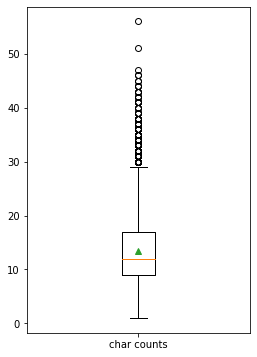

In [ ]:
plt.figure(figsize=(4, 6))
plt.boxplot(train_length, labels=['char counts'], showmeans=True)
plt.show()

## word length

In [ ]:
# document 길이 데이터
train_length = q_train.apply(lambda x:len(x.split()))
train_length.head(10)

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(train_length, bins=20, range=[0, 20], facecolor='r', label='word')
plt.title('Lengh of word')
plt.xlabel('Number of word')
plt.ylabel('Count of review')
plt.show()

In [ ]:
# 데이터 길이
print(f"word 길이 최대:    {np.max(train_length):4d}")
print(f"word 길이 최소:    {np.min(train_length):4d}")
print(f"word 길이 평균:    {np.mean(train_length):7.2f}")
print(f"word 길이 표준편차: {np.std(train_length):7.2f}")

In [ ]:
percentile25 = np.percentile(train_length, 25)
percentile50 = np.percentile(train_length, 50)
percentile75 = np.percentile(train_length, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"word 25/100분위:  {percentile25:7.2f}")
print(f"word 50/100분위:  {percentile50:7.2f}")
print(f"word 75/100분위:  {percentile75:7.2f}")
print(f"word IQR:        {percentileIQR:7.2f}")
print(f"word MAX/100분위: {percentileMAX:7.2f}")

In [ ]:
plt.figure(figsize=(4, 6))
plt.boxplot(train_length, labels=['word counts'], showmeans=True)
plt.show()

## token length

In [ ]:
# document 길이 데이터
train_length = q_train.apply(lambda x:len(vocab.encode_as_pieces(x)))
train_length.head(10)

In [ ]:
plt.figure(figsize=(8, 4))
plt.hist(train_length, bins=30, range=[0, 30], facecolor='r', label='word')
plt.title('Lengh of word')
plt.xlabel('Number of word')
plt.ylabel('Count of review')
plt.show()

In [ ]:
# 데이터 길이
print(f"token 길이 최대:    {np.max(train_length):4d}")
print(f"token 길이 최소:    {np.min(train_length):4d}")
print(f"token 길이 평균:    {np.mean(train_length):7.2f}")
print(f"token 길이 표준편차: {np.std(train_length):7.2f}")

In [ ]:
percentile25 = np.percentile(train_length, 25)
percentile50 = np.percentile(train_length, 50)
percentile75 = np.percentile(train_length, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"token 25/100분위:  {percentile25:7.2f}")
print(f"token 50/100분위:  {percentile50:7.2f}")
print(f"token 75/100분위:  {percentile75:7.2f}")
print(f"token IQR:        {percentileIQR:7.2f}")
print(f"token MAX/100분위: {percentileMAX:7.2f}")

In [ ]:
plt.figure(figsize=(4, 6))
plt.boxplot(train_length, labels=['token counts'], showmeans=True)
plt.show()

## Label Count

In [ ]:
label_count = df_train['is_duplicate'].value_counts()
label_count

In [ ]:
# label count
print(f"같은 질문 개수: {label_count[0]}")
print(f"다른 질문 개수: {label_count[1]}")

In [ ]:
# 한글 설정
plt.rc('font', family="NanumBarunGothic")
plt.rcParams["axes.unicode_minus"] = False # 한글 폰트 사용시 - 깨지는 문제 해결
plt.bar(["같음", "다름"], label_count)
plt.show()

In [ ]:
# 같음과 다름 데이타를 밸런스하게 맞추기
train_sam_data = df_train.loc[df_train['is_duplicate'] == 1]
train_nos_data = df_train.loc[df_train['is_duplicate'] == 0]
class_difference = len(train_nos_data) - len(train_sam_data)
sample_frac = 1 - (class_difference / len(train_nos_data))
train_nos_data = train_nos_data.sample(frac = sample_frac)
print("같은 질문 갯수: {}".format(len(train_sam_data)))
print("다른 질문 갯수: {}".format(len(train_nos_data)))

같은 질문 갯수: 2138
다른 질문 갯수: 2138


## Word Cloud

In [ ]:
train_question = [question for question in q_train if type(question) is str]
train_question[:10]

['1000일 만난 여자친구와 이별',
 '10년 연애사 되돌아보니 다 부질없네',
 '10년만나다 헤어지네',
 '10월의 마지막밤 . 더 보고싶네 그사람',
 '14년의 기나긴 이야기.',
 '15년만에 쓰는 편지.',
 '1년 반.',
 '1년동거 끝에 헤어짐',
 '1년만에 다시헤어지게 됐네',
 '1년을 넘게 만났는데 어떻게 이럽니까']

In [ ]:
from wordcloud import WordCloud

In [ ]:
" ".join(train_question[:10])

'1000일 만난 여자친구와 이별 10년 연애사 되돌아보니 다 부질없네 10년만나다 헤어지네 10월의 마지막밤 . 더 보고싶네 그사람 14년의 기나긴 이야기. 15년만에 쓰는 편지. 1년 반. 1년동거 끝에 헤어짐 1년만에 다시헤어지게 됐네 1년을 넘게 만났는데 어떻게 이럽니까'

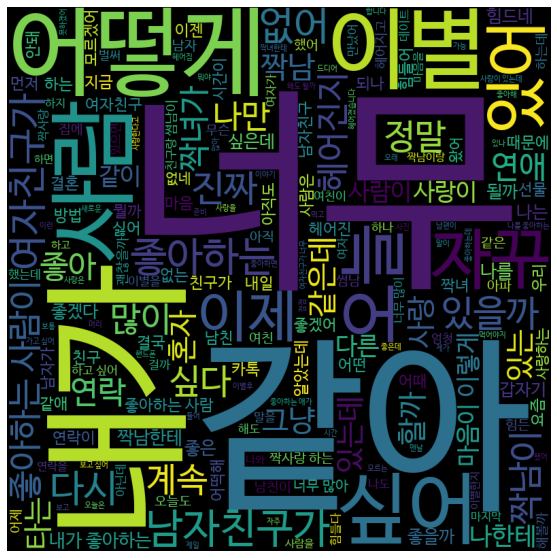

In [ ]:
wordcloud = WordCloud(width=800, height=800, font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf').generate(" ".join(train_question))
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Small Data Project (Type1)

## Train, Test 데이터 생성

In [ ]:
df_train = pd.read_csv('kor_pair_train.csv', delimiter=',')
df_train

In [ ]:
df_train = df_train.dropna()
df_train

In [ ]:
df_train = df_train.sample(10)
df_train

In [ ]:
df_test = pd.read_csv('kor_Pair_test.csv', delimiter=',')
df_test

In [ ]:
df_test.dropna()

In [ ]:
df_test = df_test[['test_id', 'question1', 'question2', 'is_duplicate']]
df_test

In [ ]:
df_test = df_test.dropna()
df_test

In [ ]:
df_test = df_test.sample(10)
df_test

In [ ]:
def make_data(df, vocab, n_seq):
    inputs_1, inputs_2, labels = [], [], []

    for i, row in tqdm(df.iterrows(), total=len(df)):
        is_duplicate = 1 - row["is_duplicate"]  # 0 -> 1, 1 -> 0

        question1 = row["question1"]
        token1 = vocab.encode_as_ids(question1)[:n_seq]
        token1 = token1 + [0] * (n_seq - len(token1))

        question2 = row["question2"]
        token2 = vocab.encode_as_ids(question2)[:n_seq]
        token2 = token2 + [0] * (n_seq - len(token2))

        assert len(token1) == n_seq
        assert len(token2) == n_seq

        print(is_duplicate, len(token1), token1, len(token2), token2)
        
        inputs_1.append(token1)
        inputs_2.append(token2)
        labels.append(is_duplicate)

    inputs_1 = np.array(inputs_1)
    inputs_2 = np.array(inputs_2)
    labels = np.array(labels)
    return inputs_1, inputs_2, labels

In [ ]:
train_inputs_1, train_inputs_2, train_labels = make_data(df_train, vocab, 16)
train_inputs_1, train_inputs_2, train_labels

In [ ]:
test_inputs_1, test_inputs_2, test_labels = make_data(df_test, vocab, 16)
test_inputs_1, test_inputs_2, test_labels

## Modeling

In [ ]:
args.n_vocab = len(vocab)
args.d_model = 256
args.n_out = 2
args

Namespace(d_model=256, n_out=2, n_vocab=32007, seed=1234)

In [ ]:
def build_model_type1(args):
    inputs_1 = tf.keras.layers.Input((None,))  # (bs, n_seq_1)
    inputs_2 = tf.keras.layers.Input((None,))  # (bs, n_seq_2)

    embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model)
    hidden_1 = embedding(inputs_1)  # (bs, n_seq_1, d_model)
    hidden_2 = embedding(inputs_2)  # (bs, n_seq_2, d_model)
    #
    # RNN, CNN, Attention, Linear
    #
    pool = tf.keras.layers.GlobalMaxPooling1D()
    hidden_1 = pool(hidden_1)  # (bs, d_model)
    hidden_2 = pool(hidden_2)  # (bs, d_model)
    distance = hidden_1 - hidden_2  # (bs, d_model)

    linear = tf.keras.layers.Dense(args.n_out, activation=tf.nn.softmax)
    y_pred = linear(distance)  # (bs, n_out)

    model = tf.keras.Model(inputs=(inputs_1, inputs_2), outputs=y_pred)
    return model

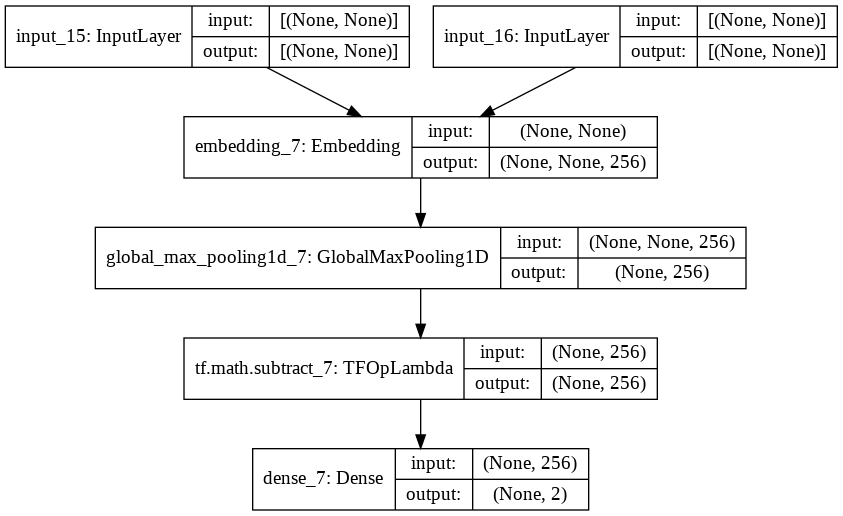

In [ ]:
model = build_model_type1(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.predict((train_inputs_1[:4], train_inputs_2[:4]))

array([[0.50180215, 0.4981979 ],
       [0.5022769 , 0.49772307],
       [0.50151885, 0.49848112],
       [0.5035796 , 0.49642032]], dtype=float32)

In [ ]:
model.predict((test_inputs_1[:4], test_inputs_2[:4]))

array([[0.5043819 , 0.49561808],
       [0.5006405 , 0.49935952],
       [0.49980924, 0.5001908 ],
       [0.49282715, 0.5071729 ]], dtype=float32)

## Train

In [ ]:
model = build_model_type1(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(qp_dir, "type1.hdf5"),
                                                  monitor='val_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(qp_dir, "type1.csv"))

In [ ]:
history = model.fit((train_inputs_1, train_inputs_2), train_labels,
                    epochs=100,
                    batch_size=512,
                    validation_data=((test_inputs_1, test_inputs_2), test_labels),
                    callbacks=[early_stopping, save_weights, csv_logger])

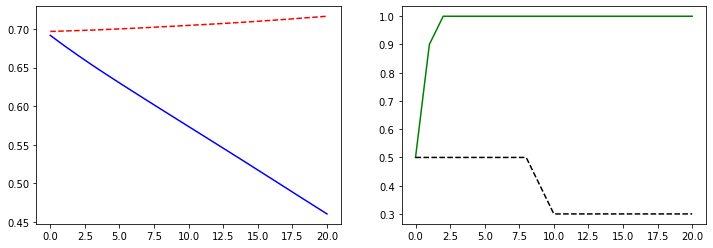

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')

plt.show()

## 평가

In [ ]:
model = build_model_type1(args)
model.load_weights(os.path.join(qp_dir, "type1.hdf5"))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
model.evaluate((test_inputs_1, test_inputs_2), test_labels)

1/1 [==============================] - 0s 257ms/step - loss: 0.6969 - accuracy: 0.5000


[0.6969453692436218, 0.5]

In [ ]:
y_pred = model.predict((test_inputs_1, test_inputs_2))
y_pred

array([[0.48296806, 0.51703197],
       [0.48669788, 0.513302  ],
       [0.5038641 , 0.49613586],
       [0.49383795, 0.5061621 ],
       [0.5036498 , 0.4963502 ],
       [0.50548464, 0.49451536],
       [0.49622536, 0.5037746 ],
       [0.49691072, 0.50308925],
       [0.49277154, 0.50722843],
       [0.5118374 , 0.48816258]], dtype=float32)

In [ ]:
y_class = np.argmax(y_pred, axis=-1)
y_class

array([1, 1, 0, 1, 0, 0, 1, 1, 1, 0])

In [ ]:
cf_matrix = np.zeros((2, 2)).astype(np.int)
cf_matrix

array([[0, 0],
       [0, 0]])

In [ ]:
for y_true, y_pred in zip(test_labels, y_class):
    cf_matrix[int(y_true), int(y_pred)] += 1
cf_matrix

array([[4, 5],
       [0, 1]])

In [ ]:
tp = cf_matrix[1, 1]
tn = cf_matrix[0, 0]
fp = cf_matrix[0, 1]
fn = cf_matrix[1, 0]

accuracy = (tp + tn) / max((tp + tn + fp + fn), 1)
print(f'accuracy: {accuracy}')
precision = (tp) / max((tp + fp), 1)
print(f'precision: {precision}')
recall = (tp) / max((tp + fn), 1)
print(f'recall: {recall}')
f1 = 2 * (precision * recall) / max((precision + recall), 1)
print(f'f1: {f1}')

accuracy: 0.5
precision: 0.16666666666666666
recall: 1.0
f1: 0.2857142857142857


## 배포

In [ ]:
model = build_model_type1(args)
model.load_weights(os.path.join(qp_dir, "type1.hdf5"))

In [ ]:
string1 = "영화 너무 심심해"
string2 = "영화 너무 재밌고 좋아"

In [ ]:
vocab.encode_as_pieces(string1), vocab.encode_as_pieces(string2)

(['▁영화', '▁너무', '▁심', '심', '해'], ['▁영화', '▁너무', '▁재', '밌', '고', '▁좋아'])

In [ ]:
infer_input_1 = vocab.encode_as_ids(string1)
infer_input_1 = np.array([infer_input_1])
infer_input_1

array([[ 283, 2364,  732,  690,   61]])

In [ ]:
infer_input_2 = vocab.encode_as_ids(string2)
infer_input_2 = np.array([infer_input_2])
infer_input_2

array([[  283,  2364,   480, 31756,    37,  3099]])

In [ ]:
y_pred = model.predict((infer_input_1, infer_input_2))
y_pred

array([[0.50452197, 0.49547803]], dtype=float32)

In [ ]:
y_class = np.argmax(y_pred, axis=-1)[0]
y_class

0

In [ ]:
print(f"{string1} / {string2} : {id_to_label[y_class]}")

영화 너무 심심해 / 영화 너무 재밌고 좋아 : 다른 질문


In [ ]:
def do_predict(model, string1, string2):
    infer_input_1 = vocab.encode_as_ids(string1)
    infer_input_1 = np.array([infer_input_1])

    infer_input_2 = vocab.encode_as_ids(string2)
    infer_input_2 = np.array([infer_input_2])

    y_pred = model.predict((infer_input_1, infer_input_2))
    y_class = np.argmax(y_pred, axis=-1)[0]
    return id_to_label[y_class]

In [ ]:
do_predict(model, string1, string2)

'다른 질문'

In [ ]:
while True:
    print("input 1> ", end="")
    string1 = str(input())
    if len(string1) == 0:
        break
    print("input 2> ", end="")
    string2 = str(input())
    if len(string2) == 0:
        break
    result = do_predict(model, string1, string2)
    print(result)

input 1> 오늘 배고가
input 2> 너무 많이 먹었어
같은 질문
input 1> 


# All Data Project (Type1)

## Train, Test 데이터 생성

In [ ]:
df_train = pd.read_csv('kor_pair_train.csv', delimiter=',')
df_train

,id,qid1,qid2,question1,question2,is_duplicate
0,1,1,2,1000일 만난 여자친구와 이별,10년 연예의끝,1
1,2,3,4,10년 연애사 되돌아보니 다 부질없네,10년이라는 시간이 참 무색하다 싶네,1
2,3,5,6,10년만나다 헤어지네,14년된 여자친구랑 이별,1
3,4,7,8,10월의 마지막밤 . 더 보고싶네 그사람,15년…안녕,1
4,5,9,10,14년의 기나긴 이야기.,1년 9개월 의 연애 종지부.,1
...,...,...,...,...,...,...
6883,6884,13767,13768,O형 남자와 썸을 타는데,O형 여자와 썸을 타는데,1
6884,6885,13769,13770,SD카드 안돼,SD카드 망가졌어,0
6885,6886,13771,13772,SNS 를 끊어야 하는데.,가슴 아픈 이별,1
6886,6887,13773,13774,SNS 시간낭비인데 자꾸 보게됨,SNS 시간낭비인 거 아는데 매일 하는 중,0


In [ ]:
df_train = df_train.dropna()
df_train

,id,qid1,qid2,question1,question2,is_duplicate
0,1,1,2,1000일 만난 여자친구와 이별,10년 연예의끝,1
1,2,3,4,10년 연애사 되돌아보니 다 부질없네,10년이라는 시간이 참 무색하다 싶네,1
2,3,5,6,10년만나다 헤어지네,14년된 여자친구랑 이별,1
3,4,7,8,10월의 마지막밤 . 더 보고싶네 그사람,15년…안녕,1
4,5,9,10,14년의 기나긴 이야기.,1년 9개월 의 연애 종지부.,1
...,...,...,...,...,...,...
6883,6884,13767,13768,O형 남자와 썸을 타는데,O형 여자와 썸을 타는데,1
6884,6885,13769,13770,SD카드 안돼,SD카드 망가졌어,0
6885,6886,13771,13772,SNS 를 끊어야 하는데.,가슴 아픈 이별,1
6886,6887,13773,13774,SNS 시간낭비인데 자꾸 보게됨,SNS 시간낭비인 거 아는데 매일 하는 중,0


In [ ]:
df_test = pd.read_csv('kor_Pair_test.csv', delimiter=',')
df_test

,test_id,question1,question2,is_duplicate,Unnamed: 4
0,1,21살의 사랑에 대해,사랑을 노력한다는게 말이 되나요?,1,NaN
1,2,2년 가량의 연애,2년 만났어,0,NaN
2,3,2년 만난 기념일이야,우리 벌써 2년 동안 사궜어,0,NaN
3,4,2년 사귀었는데 결혼하려고,2년째 짝사랑하는 사람이 있어.,1,NaN
4,5,5급면제도 나랑사랑카드 발급하나요?,아이콘 노래 사랑을 했다 별로인것같은데,1,NaN
...,...,...,...,...,...
683,684,회사에서 짤릴 필이 와,나 회사 짤릴 거 같은데 어떻게 만회하지,0,1.0
684,685,효율적으로 공부하는 방법,새 해 결심 뭐였더라,1,NaN
685,686,휴대폰 액정 깨졌어,액정 깨짐,0,NaN
686,687,힘든 일이 너무 많아요,괜찮아 천천히 해도 돼,1,NaN


In [ ]:
df_test.dropna()

,test_id,question1,question2,is_duplicate,Unnamed: 4
683,684,회사에서 짤릴 필이 와,나 회사 짤릴 거 같은데 어떻게 만회하지,0,1.0


In [ ]:
df_test = df_test[['test_id', 'question1', 'question2', 'is_duplicate']]
df_test

,test_id,question1,question2,is_duplicate
0,1,21살의 사랑에 대해,사랑을 노력한다는게 말이 되나요?,1
1,2,2년 가량의 연애,2년 만났어,0
2,3,2년 만난 기념일이야,우리 벌써 2년 동안 사궜어,0
3,4,2년 사귀었는데 결혼하려고,2년째 짝사랑하는 사람이 있어.,1
4,5,5급면제도 나랑사랑카드 발급하나요?,아이콘 노래 사랑을 했다 별로인것같은데,1
...,...,...,...,...
683,684,회사에서 짤릴 필이 와,나 회사 짤릴 거 같은데 어떻게 만회하지,0
684,685,효율적으로 공부하는 방법,새 해 결심 뭐였더라,1
685,686,휴대폰 액정 깨졌어,액정 깨짐,0
686,687,힘든 일이 너무 많아요,괜찮아 천천히 해도 돼,1


In [ ]:
df_test = df_test.dropna()
df_test

,test_id,question1,question2,is_duplicate
0,1,21살의 사랑에 대해,사랑을 노력한다는게 말이 되나요?,1
1,2,2년 가량의 연애,2년 만났어,0
2,3,2년 만난 기념일이야,우리 벌써 2년 동안 사궜어,0
3,4,2년 사귀었는데 결혼하려고,2년째 짝사랑하는 사람이 있어.,1
4,5,5급면제도 나랑사랑카드 발급하나요?,아이콘 노래 사랑을 했다 별로인것같은데,1
...,...,...,...,...
683,684,회사에서 짤릴 필이 와,나 회사 짤릴 거 같은데 어떻게 만회하지,0
684,685,효율적으로 공부하는 방법,새 해 결심 뭐였더라,1
685,686,휴대폰 액정 깨졌어,액정 깨짐,0
686,687,힘든 일이 너무 많아요,괜찮아 천천히 해도 돼,1


In [ ]:
def make_data(df, vocab, n_seq):
    inputs_1, inputs_2, labels = [], [], []

    for i, row in tqdm(df.iterrows(), total=len(df)):
        is_duplicate = 1 - row["is_duplicate"]  # 0 -> 1, 1 -> 0

        question1 = row["question1"]
        token1 = vocab.encode_as_ids(question1)[:n_seq]
        token1 = token1 + [0] * (n_seq - len(token1))

        question2 = row["question2"]
        token2 = vocab.encode_as_ids(question2)[:n_seq]
        token2 = token2 + [0] * (n_seq - len(token2))

        assert len(token1) == n_seq
        assert len(token2) == n_seq

        # print(is_duplicate, len(token1), token1, len(token2), token2)
        
        inputs_1.append(token1)
        inputs_2.append(token2)
        labels.append(is_duplicate)

    inputs_1 = np.array(inputs_1)
    inputs_2 = np.array(inputs_2)
    labels = np.array(labels)
    return inputs_1, inputs_2, labels

In [ ]:
train_inputs_1, train_inputs_2, train_labels = make_data(df_train, vocab, 16)
train_inputs_1, train_inputs_2, train_labels

(array([[ 4163,    30,  6123, ...,     0,     0,     0],
        [   67,    17,  7479, ...,     0,     0,     0],
        [   67,    17,    59, ...,     0,     0,     0],
        ...,
        [22410,    10,    15, ...,     0,     0,     0],
        [22410,  1034,  4274, ...,     0,     0,     0],
        [ 2425, 13884,    23, ...,     0,     0,     0]]),
 array([[   67,    17, 10200, ...,     0,     0,     0],
        [   67,    17,   210, ...,     0,     0,     0],
        [  246,    17,    79, ...,     0,     0,     0],
        ...,
        [ 5832,   199, 11074, ...,     0,     0,     0],
        [22410,  1034,  4274, ...,     0,     0,     0],
        [20650, 21957,  2364, ...,     0,     0,     0]]),
 array([0, 0, 0, ..., 0, 1, 0]))

In [ ]:
test_inputs_1, test_inputs_2, test_labels = make_data(df_test, vocab, 16)
test_inputs_1, test_inputs_2, test_labels

(array([[  531, 12785, 15185, ...,     0,     0,     0],
        [   38,    17,  5960, ...,     0,     0,     0],
        [   38,    17,  6123, ...,     0,     0,     0],
        ...,
        [18402, 26008,  5563, ...,     0,     0,     0],
        [10149,  2156,  2364, ...,     0,     0,     0],
        [   10, 11734,    32, ...,     0,     0,     0]]),
 array([[ 5251,  1530,  1932, ...,     0,     0,     0],
        [   38,    17, 13297, ...,     0,     0,     0],
        [ 1074, 27731,    38, ...,     0,     0,     0],
        ...,
        [26008,  5563,  5394, ...,     0,     0,     0],
        [   10, 31855, 14969, ...,     0,     0,     0],
        [ 1118,  3327,    18, ...,     0,     0,     0]]),
 array([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
        0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

## Modeling

In [ ]:
args.n_vocab = len(vocab)
args.d_model = 256
args.n_out = 2
args

Namespace(d_model=256, n_out=2, n_vocab=32007, seed=1234)

In [ ]:
def build_model_type1(args):
    inputs_1 = tf.keras.layers.Input((None,))  # (bs, n_seq_1)
    inputs_2 = tf.keras.layers.Input((None,))  # (bs, n_seq_2)

    embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model)
    hidden_1 = embedding(inputs_1)  # (bs, n_seq_1, d_model)
    hidden_2 = embedding(inputs_2)  # (bs, n_seq_2, d_model)
    
    conv3 = tf.keras.layers.Conv1D(100, kernel_size=3, padding="same")
    hidden_13 = conv3(hidden_1)  # (bs, n_seq_1, 100)
    hidden_23 = conv3(hidden_1)  # (bs, n_seq_2, 100)

    conv4 = tf.keras.layers.Conv1D(100, kernel_size=4, padding="same")
    hidden_14 = conv4(hidden_1)  # (bs, n_seq_1, 100)
    hidden_24 = conv4(hidden_1)  # (bs, n_seq_2, 100)

    conv5 = tf.keras.layers.Conv1D(100, kernel_size=5, padding="same")
    hidden_15 = conv5(hidden_1)  # (bs, n_seq_1, 100)
    hidden_25 = conv5(hidden_1)  # (bs, n_seq_2, 100)

    pool = tf.keras.layers.GlobalMaxPooling1D()
    hidden_13 = pool(hidden_13)  # (bs, 100)
    hidden_14 = pool(hidden_14)  # (bs, 100)
    hidden_15 = pool(hidden_15)  # (bs, 100)
    hidden_1 = tf.concat([hidden_13, hidden_14, hidden_15], axis=-1)  # (bs, 100 * 3)

    hidden_23 = pool(hidden_23)  # (bs, 100)
    hidden_24 = pool(hidden_24)  # (bs, 100)
    hidden_25 = pool(hidden_25)  # (bs, 100)
    hidden_2 = tf.concat([hidden_23, hidden_24, hidden_25], axis=-1)  # (bs, 100 * 3)

    distance = hidden_1 - hidden_2  # (bs, d_model)

    linear = tf.keras.layers.Dense(args.n_out, activation=tf.nn.softmax)
    y_pred = linear(distance)  # (bs, n_out)

    model = tf.keras.Model(inputs=(inputs_1, inputs_2), outputs=y_pred)
    return model

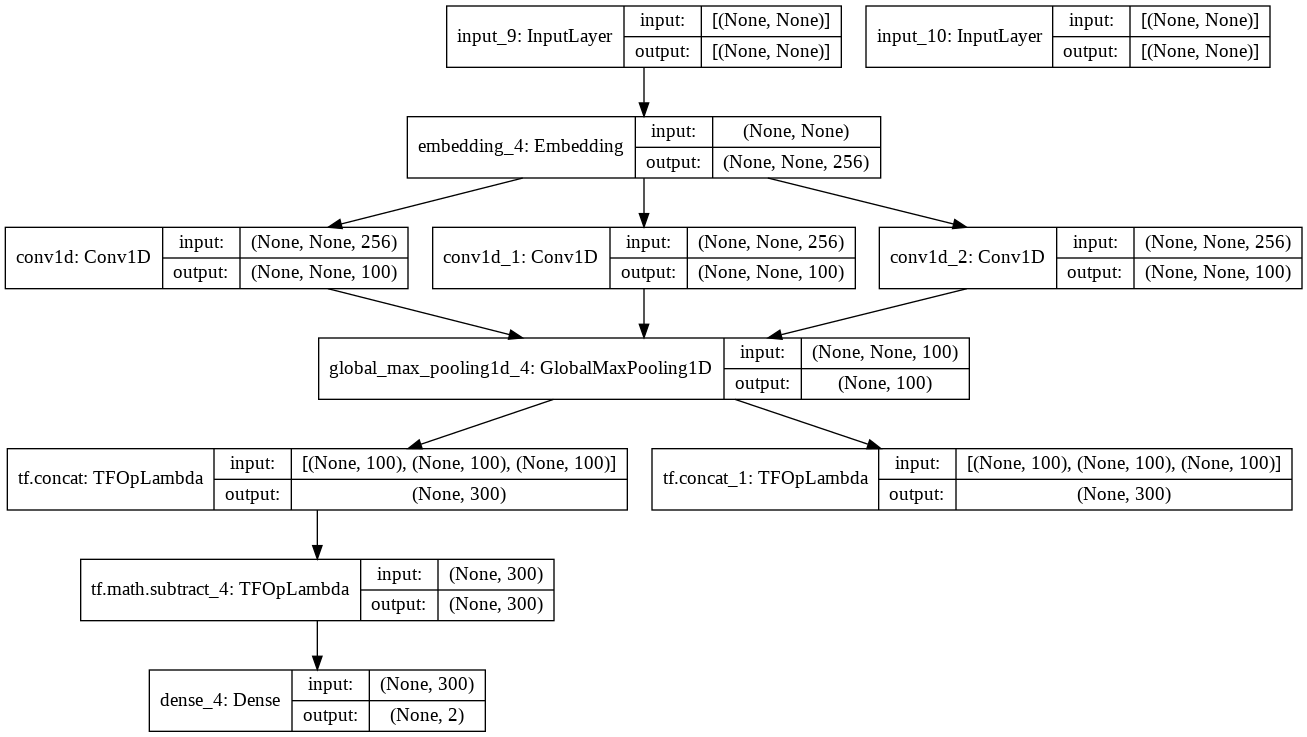

In [ ]:
model = build_model_type1(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.predict((train_inputs_1[:4], train_inputs_2[:4]))

array([[0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5]], dtype=float32)

In [ ]:
model.predict((test_inputs_1[:4], test_inputs_2[:4]))

array([[0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5]], dtype=float32)

## Train

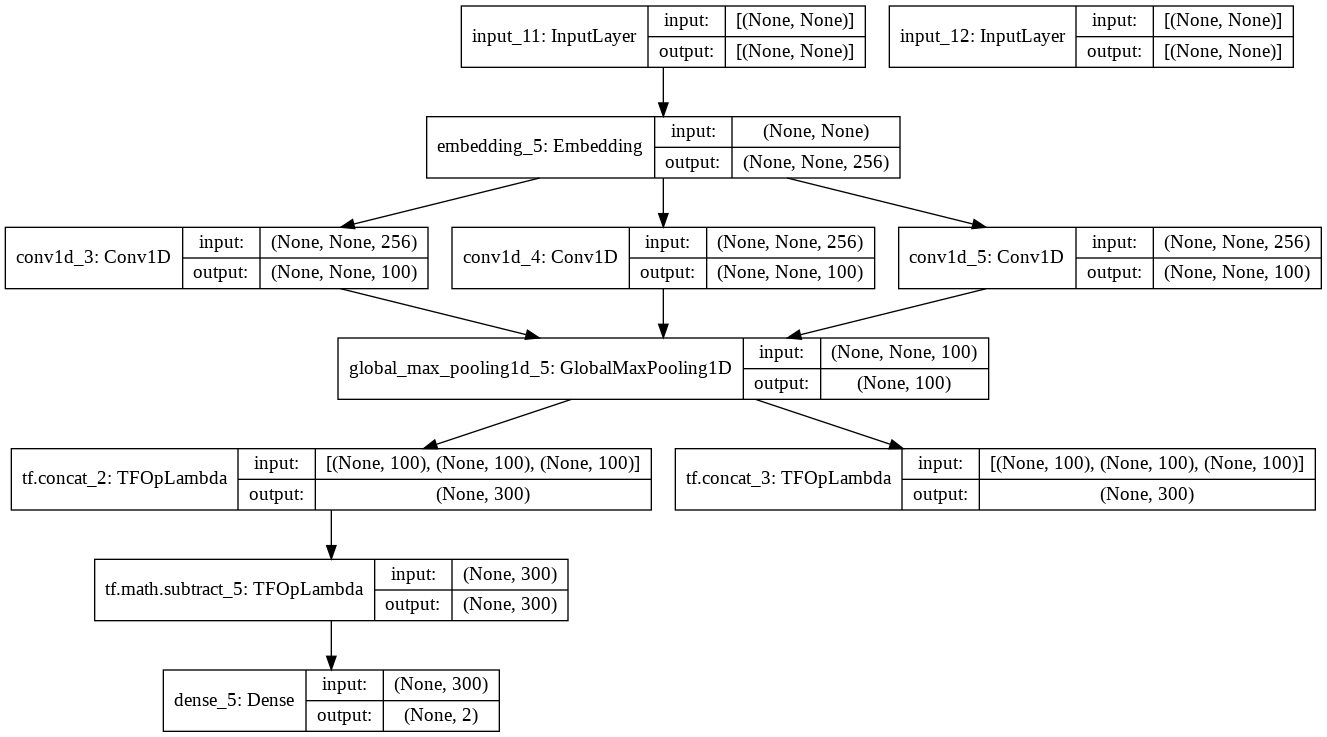

In [ ]:
model = build_model_type1(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(qp_dir, "type1.hdf5"),
                                                  monitor='val_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(qp_dir, "type1.csv"))

In [ ]:
history = model.fit((train_inputs_1, train_inputs_2), train_labels,
                    epochs=100,
                    batch_size=512,
                    validation_data=((test_inputs_1, test_inputs_2), test_labels),
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/100
14/14 [==============================] - 3s 134ms/step - loss: 0.6918 - accuracy: 0.6069 - val_loss: 0.6926 - val_accuracy: 0.5218

Epoch 00001: val_accuracy improved from -inf to 0.52180, saving model to /content/drive/MyDrive/Data/nlp/question_pair/type1.hdf5
Epoch 2/100
14/14 [==============================] - 1s 96ms/step - loss: 0.6868 - accuracy: 0.6863 - val_loss: 0.6923 - val_accuracy: 0.5218

Epoch 00002: val_accuracy did not improve from 0.52180
Epoch 3/100
14/14 [==============================] - 1s 97ms/step - loss: 0.6819 - accuracy: 0.6889 - val_loss: 0.6922 - val_accuracy: 0.5218

Epoch 00003: val_accuracy did not improve from 0.52180
Epoch 4/100
14/14 [==============================] - 1s 108ms/step - loss: 0.6770 - accuracy: 0.6914 - val_loss: 0.6923 - val_accuracy: 0.5218

Epoch 00004: val_accuracy did not improve from 0.52180
Epoch 5/100
14/14 [==============================] - 1s 94ms/step - loss: 0.6726 - accuracy: 0.6916 - val_loss: 0.6925 - val_accura

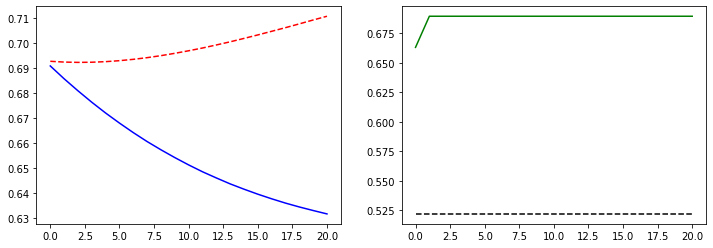

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')

plt.show()

## 평가

In [ ]:
model = build_model_type1(args)
model.load_weights(os.path.join(qp_dir, "type1.hdf5"))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
model.evaluate((test_inputs_1, test_inputs_2), test_labels)

22/22 [==============================] - 0s 4ms/step - loss: 0.6927 - accuracy: 0.5195


[0.6926339864730835, 0.5218023061752319]

In [ ]:
y_pred = model.predict((test_inputs_1, test_inputs_2))
y_pred

array([[0.49298772, 0.5070123 ],
       [0.49298772, 0.5070123 ],
       [0.49298772, 0.5070123 ],
       ...,
       [0.49298772, 0.5070123 ],
       [0.49298772, 0.5070123 ],
       [0.49298772, 0.5070123 ]], dtype=float32)

In [ ]:
y_class = np.argmax(y_pred, axis=-1)
y_class

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
cf_matrix = np.zeros((2, 2)).astype(np.int)
cf_matrix

array([[0, 0],
       [0, 0]])

In [ ]:
for y_true, y_pred in zip(test_labels, y_class):
    cf_matrix[int(y_true), int(y_pred)] += 1
cf_matrix

array([[  0, 329],
       [  0, 359]])

In [ ]:
tp = cf_matrix[1, 1]
tn = cf_matrix[0, 0]
fp = cf_matrix[0, 1]
fn = cf_matrix[1, 0]

accuracy = (tp + tn) / max((tp + tn + fp + fn), 1)
print(f'accuracy: {accuracy}')
precision = (tp) / max((tp + fp), 1)
print(f'precision: {precision}')
recall = (tp) / max((tp + fn), 1)
print(f'recall: {recall}')
f1 = 2 * (precision * recall) / max((precision + recall), 1)
print(f'f1: {f1}')

accuracy: 0.5218023255813954
precision: 0.5218023255813954
recall: 1.0
f1: 0.6857688634192933


## 배포

In [ ]:
model = build_model_type1(args)
model.load_weights(os.path.join(qp_dir, "type1.hdf5"))

In [ ]:
string1 = "영화 너무 심심해"
string2 = "영화 너무 재밌고 좋아"

In [ ]:
vocab.encode_as_pieces(string1), vocab.encode_as_pieces(string2)

(['▁영화', '▁너무', '▁심', '심', '해'], ['▁영화', '▁너무', '▁재', '밌', '고', '▁좋아'])

In [ ]:
infer_input_1 = vocab.encode_as_ids(string1)
infer_input_1 = np.array([infer_input_1])
infer_input_1

array([[ 283, 2364,  732,  690,   61]])

In [ ]:
infer_input_2 = vocab.encode_as_ids(string2)
infer_input_2 = np.array([infer_input_2])
infer_input_2

array([[  283,  2364,   480, 31756,    37,  3099]])

In [ ]:
y_pred = model.predict((infer_input_1, infer_input_2))
y_pred

array([[0.6807092 , 0.31929085]], dtype=float32)

In [ ]:
y_class = np.argmax(y_pred, axis=-1)[0]
y_class

0

In [ ]:
print(f"{string1} / {string2} : {id_to_label[y_class]}")

영화 너무 심심해 / 영화 너무 재밌고 좋아 : 다른 질문


In [ ]:
def do_predict(model, string1, string2):
    infer_input_1 = vocab.encode_as_ids(string1)
    infer_input_1 = np.array([infer_input_1])

    infer_input_2 = vocab.encode_as_ids(string2)
    infer_input_2 = np.array([infer_input_2])

    y_pred = model.predict((infer_input_1, infer_input_2))
    y_class = np.argmax(y_pred, axis=-1)[0]
    return id_to_label[y_class]

In [ ]:
do_predict(model, string1, string2)

'다른 질문'

In [ ]:
while True:
    print("input 1> ", end="")
    string1 = str(input())
    if len(string1) == 0:
        break
    print("input 2> ", end="")
    string2 = str(input())
    if len(string2) == 0:
        break
    result = do_predict(model, string1, string2)
    print(result)

input 1> 


# All Data Project (Type2)

## Train, Test 데이터 생성

In [ ]:
df_train = pd.read_csv('kor_pair_train.csv', delimiter=',')
df_train = df_train.dropna()
# df_train = df_train.sample(10)
df_train

,id,qid1,qid2,question1,question2,is_duplicate
0,1,1,2,1000일 만난 여자친구와 이별,10년 연예의끝,1
1,2,3,4,10년 연애사 되돌아보니 다 부질없네,10년이라는 시간이 참 무색하다 싶네,1
2,3,5,6,10년만나다 헤어지네,14년된 여자친구랑 이별,1
3,4,7,8,10월의 마지막밤 . 더 보고싶네 그사람,15년…안녕,1
4,5,9,10,14년의 기나긴 이야기.,1년 9개월 의 연애 종지부.,1
...,...,...,...,...,...,...
6883,6884,13767,13768,O형 남자와 썸을 타는데,O형 여자와 썸을 타는데,1
6884,6885,13769,13770,SD카드 안돼,SD카드 망가졌어,0
6885,6886,13771,13772,SNS 를 끊어야 하는데.,가슴 아픈 이별,1
6886,6887,13773,13774,SNS 시간낭비인데 자꾸 보게됨,SNS 시간낭비인 거 아는데 매일 하는 중,0


In [ ]:
df_test = pd.read_csv('kor_Pair_test.csv', delimiter=',')
df_test = df_test[['test_id', 'question1', 'question2', 'is_duplicate']]
df_test = df_test.dropna()
# df_test = df_test.sample(10)
df_test

,test_id,question1,question2,is_duplicate
0,1,21살의 사랑에 대해,사랑을 노력한다는게 말이 되나요?,1
1,2,2년 가량의 연애,2년 만났어,0
2,3,2년 만난 기념일이야,우리 벌써 2년 동안 사궜어,0
3,4,2년 사귀었는데 결혼하려고,2년째 짝사랑하는 사람이 있어.,1
4,5,5급면제도 나랑사랑카드 발급하나요?,아이콘 노래 사랑을 했다 별로인것같은데,1
...,...,...,...,...
683,684,회사에서 짤릴 필이 와,나 회사 짤릴 거 같은데 어떻게 만회하지,0
684,685,효율적으로 공부하는 방법,새 해 결심 뭐였더라,1
685,686,휴대폰 액정 깨졌어,액정 깨짐,0
686,687,힘든 일이 너무 많아요,괜찮아 천천히 해도 돼,1


In [ ]:
def make_data(df, vocab, n_seq):
    inputs_1, inputs_2, labels = [], [], []

    for i, row in tqdm(df.iterrows(), total=len(df)):
        is_duplicate = 1 - row["is_duplicate"]  # 0 -> 1, 1 -> 0
        question1 = row["question1"]
        token1 = vocab.encode_as_ids(question1)[:n_seq]
        token1 = token1 + [0] * (n_seq - len(token1))
        question2 = row["question2"]
        token2 = vocab.encode_as_ids(question2)[:n_seq]
        token2 = token2 + [0] * (n_seq - len(token2))

        assert len(token1) == n_seq
        assert len(token2) == n_seq

        # print(is_duplicate, len(token1), token1, len(token2), token2)
        inputs_1.append(token1)
        inputs_2.append(token2)
        labels.append(is_duplicate)

    inputs_1 = np.array(inputs_1)
    inputs_2 = np.array(inputs_2)
    labels = np.array(labels)
    return inputs_1, inputs_2, labels

In [ ]:
train_inputs_1, train_inputs_2, train_labels = make_data(df_train, vocab, 16)
train_inputs_1, train_inputs_2, train_labels

(array([[ 4163,    30,  6123, ...,     0,     0,     0],
        [   67,    17,  7479, ...,     0,     0,     0],
        [   67,    17,    59, ...,     0,     0,     0],
        ...,
        [22410,    10,    15, ...,     0,     0,     0],
        [22410,  1034,  4274, ...,     0,     0,     0],
        [ 2425, 13884,    23, ...,     0,     0,     0]]),
 array([[   67,    17, 10200, ...,     0,     0,     0],
        [   67,    17,   210, ...,     0,     0,     0],
        [  246,    17,    79, ...,     0,     0,     0],
        ...,
        [ 5832,   199, 11074, ...,     0,     0,     0],
        [22410,  1034,  4274, ...,     0,     0,     0],
        [20650, 21957,  2364, ...,     0,     0,     0]]),
 array([0, 0, 0, ..., 0, 1, 0]))

In [ ]:
test_inputs_1, test_inputs_2, test_labels = make_data(df_test, vocab, 16)
test_inputs_1, test_inputs_2, test_labels

(array([[  531, 12785, 15185, ...,     0,     0,     0],
        [   38,    17,  5960, ...,     0,     0,     0],
        [   38,    17,  6123, ...,     0,     0,     0],
        ...,
        [18402, 26008,  5563, ...,     0,     0,     0],
        [10149,  2156,  2364, ...,     0,     0,     0],
        [   10, 11734,    32, ...,     0,     0,     0]]),
 array([[ 5251,  1530,  1932, ...,     0,     0,     0],
        [   38,    17, 13297, ...,     0,     0,     0],
        [ 1074, 27731,    38, ...,     0,     0,     0],
        ...,
        [26008,  5563,  5394, ...,     0,     0,     0],
        [   10, 31855, 14969, ...,     0,     0,     0],
        [ 1118,  3327,    18, ...,     0,     0,     0]]),
 array([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
        0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

## Modeling

In [ ]:
args.n_vocab = len(vocab)
args.d_model = 256
args.n_out = 2
args

Namespace(d_model=256, n_out=2, n_vocab=32007, seed=1234)

In [ ]:
def build_model_type2(args):
    inputs_1 = tf.keras.layers.Input((None,))  # (bs, n_seq_1)
    inputs_2 = tf.keras.layers.Input((None,))  # (bs, n_seq_2)

    embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model)
    hidden_1 = embedding(inputs_1)  # (bs, n_seq_1, d_model)
    hidden_2 = embedding(inputs_2)  # (bs, n_seq_2, d_model)
    
    conv3 = tf.keras.layers.Conv1D(100, kernel_size=3, padding="same")
    hidden_13 = conv3(hidden_1)  # (bs, n_seq_1, 100)
    hidden_23 = conv3(hidden_1)  # (bs, n_seq_2, 100)

    conv4 = tf.keras.layers.Conv1D(100, kernel_size=4, padding="same")
    hidden_14 = conv4(hidden_1)  # (bs, n_seq_1, 100)
    hidden_24 = conv4(hidden_1)  # (bs, n_seq_2, 100)

    conv5 = tf.keras.layers.Conv1D(100, kernel_size=5, padding="same")
    hidden_15 = conv5(hidden_1)  # (bs, n_seq_1, 100)
    hidden_25 = conv5(hidden_1)  # (bs, n_seq_2, 100)

    pool = tf.keras.layers.GlobalMaxPooling1D()
    hidden_13 = pool(hidden_13)  # (bs, 100)
    hidden_14 = pool(hidden_14)  # (bs, 100)
    hidden_15 = pool(hidden_15)  # (bs, 100)
    hidden_1 = tf.concat([hidden_13, hidden_14, hidden_15], axis=-1)  # (bs, 100 * 3)

    hidden_23 = pool(hidden_23)  # (bs, 100)
    hidden_24 = pool(hidden_24)  # (bs, 100)
    hidden_25 = pool(hidden_25)  # (bs, 100)
    hidden_2 = tf.concat([hidden_23, hidden_24, hidden_25], axis=-1)  # (bs, 100 * 3)

    hidden = tf.concat([hidden_1, hidden_2], axis=-1)  # (bs, 100 * 6)
    hidden = tf.keras.layers.Dropout(0.5)(hidden)

    linear = tf.keras.layers.Dense(args.n_out, activation=tf.nn.softmax)
    y_pred = linear(hidden)

    model = tf.keras.Model(inputs=(inputs_1, inputs_2), outputs=y_pred)
    return model

In [ ]:
model = build_model_type2(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.predict((train_inputs_1[:4], train_inputs_2[:4]))

array([[0.48670894, 0.51329106],
       [0.47291413, 0.5270859 ],
       [0.48125577, 0.51874423],
       [0.4922821 , 0.5077179 ]], dtype=float32)

In [ ]:
model.predict((test_inputs_1[:4], test_inputs_2[:4]))

array([[0.47798014, 0.52201986],
       [0.48756304, 0.5124369 ],
       [0.4844921 , 0.5155079 ],
       [0.4878989 , 0.5121012 ]], dtype=float32)

## Train

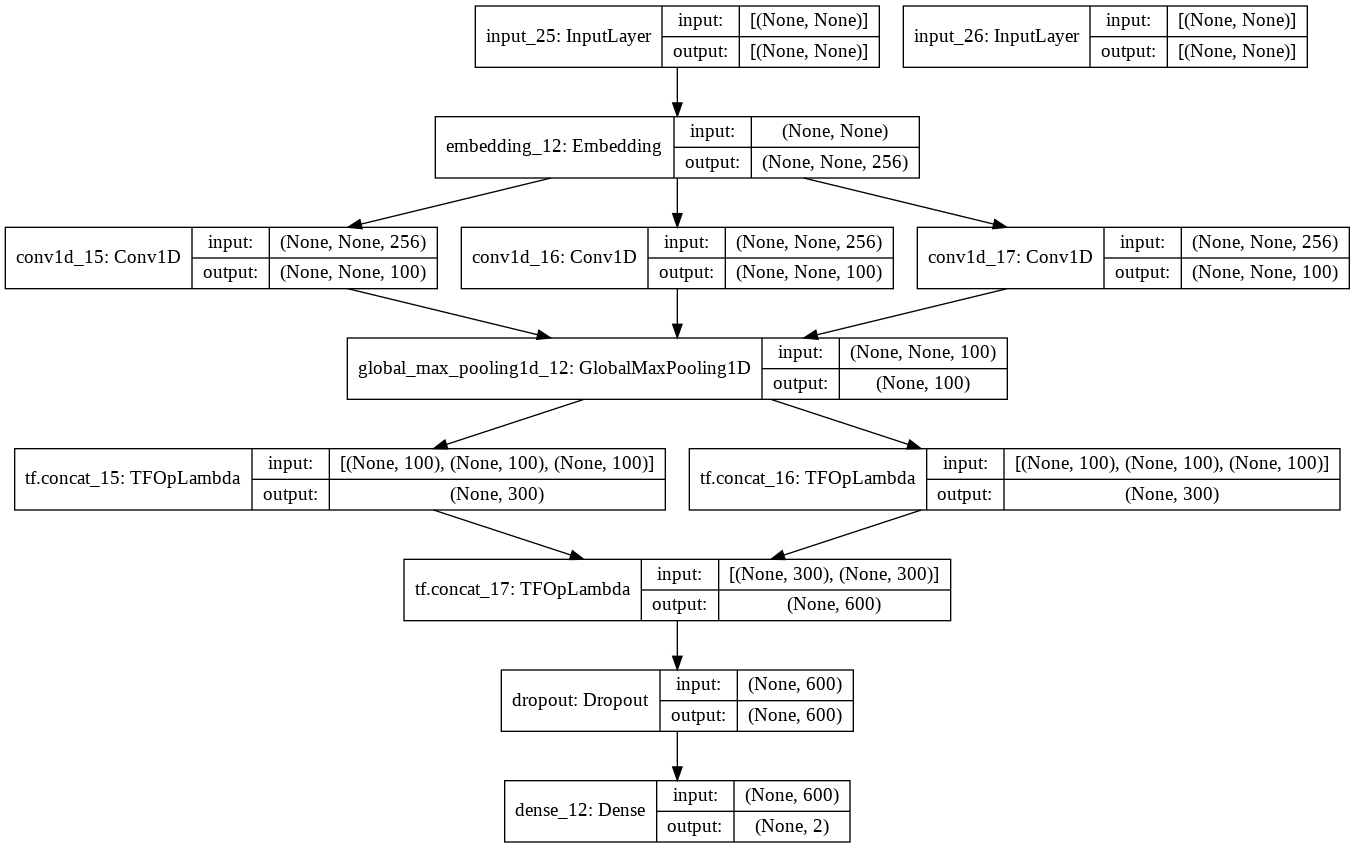

In [ ]:
model = build_model_type2(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(qp_dir, "type2.hdf5"),
                                                  monitor='val_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(qp_dir, "type2.csv"))

In [ ]:
history = model.fit((train_inputs_1, train_inputs_2), train_labels,
                    epochs=100,
                    batch_size=64,
                    validation_data=((test_inputs_1, test_inputs_2), test_labels),
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/100
108/108 [==============================] - 10s 84ms/step - loss: 0.5782 - accuracy: 0.7067 - val_loss: 0.9057 - val_accuracy: 0.5509

Epoch 00001: val_accuracy improved from -inf to 0.55087, saving model to /content/drive/MyDrive/Data/nlp/question_pair/type2.hdf5
Epoch 2/100
108/108 [==============================] - 9s 81ms/step - loss: 0.3394 - accuracy: 0.8614 - val_loss: 1.0031 - val_accuracy: 0.5843

Epoch 00002: val_accuracy improved from 0.55087 to 0.58430, saving model to /content/drive/MyDrive/Data/nlp/question_pair/type2.hdf5
Epoch 3/100
108/108 [==============================] - 9s 83ms/step - loss: 0.2174 - accuracy: 0.9205 - val_loss: 1.2714 - val_accuracy: 0.5799

Epoch 00003: val_accuracy did not improve from 0.58430
Epoch 4/100
108/108 [==============================] - 9s 82ms/step - loss: 0.1339 - accuracy: 0.9525 - val_loss: 1.5769 - val_accuracy: 0.5799

Epoch 00004: val_accuracy did not improve from 0.58430
Epoch 5/100
108/108 [=========================

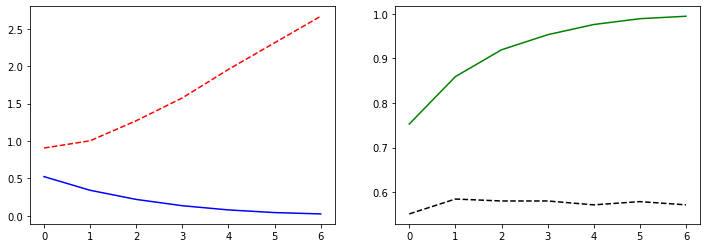

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')

plt.show()

## 평가

In [ ]:
model = build_model_type2(args)
model.load_weights(os.path.join(qp_dir, "type2.hdf5"))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
model.evaluate((test_inputs_1, test_inputs_2), test_labels)

22/22 [==============================] - 0s 3ms/step - loss: 1.0259 - accuracy: 0.5704


[1.003114938735962, 0.5843023061752319]

In [ ]:
y_pred = model.predict((test_inputs_1, test_inputs_2))
y_pred

array([[0.19802074, 0.80197924],
       [0.97867703, 0.02132297],
       [0.6356496 , 0.36435038],
       ...,
       [0.04732567, 0.9526743 ],
       [0.15761843, 0.84238154],
       [0.67617106, 0.3238289 ]], dtype=float32)

In [ ]:
y_class = np.argmax(y_pred, axis=-1)
y_class

array([1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,

In [ ]:
cf_matrix = np.zeros((2, 2)).astype(np.int)
cf_matrix

array([[0, 0],
       [0, 0]])

In [ ]:
for y_true, y_pred in zip(test_labels, y_class):
    cf_matrix[int(y_true), int(y_pred)] += 1
cf_matrix

array([[ 92, 237],
       [ 49, 310]])

In [ ]:
tp = cf_matrix[1, 1]
tn = cf_matrix[0, 0]
fp = cf_matrix[0, 1]
fn = cf_matrix[1, 0]

accuracy = (tp + tn) / max((tp + tn + fp + fn), 1)
print(f'accuracy: {accuracy}')
precision = (tp) / max((tp + fp), 1)
print(f'precision: {precision}')
recall = (tp) / max((tp + fn), 1)
print(f'recall: {recall}')
f1 = 2 * (precision * recall) / max((precision + recall), 1)
print(f'f1: {f1}')

accuracy: 0.5843023255813954
precision: 0.56672760511883
recall: 0.8635097493036211
f1: 0.6843267108167771


## 배포

In [ ]:
model = build_model_type2(args)
model.load_weights(os.path.join(qp_dir, "type2.hdf5"))

In [ ]:
def do_predict(model, string1, string2):
    infer_input_1 = vocab.encode_as_ids(string1)
    infer_input_1 = np.array([infer_input_1])

    infer_input_2 = vocab.encode_as_ids(string2)
    infer_input_2 = np.array([infer_input_2])

    y_pred = model.predict((infer_input_1, infer_input_2))
    y_class = np.argmax(y_pred, axis=-1)[0]
    return id_to_label[y_class]

In [ ]:
while True:
    print("input 1> ", end="")
    string1 = str(input())
    if len(string1) == 0:
        break
    print("input 2> ", end="")
    string2 = str(input())
    if len(string2) == 0:
        break
    result = do_predict(model, string1, string2)
    print(result)

input 1> 많이 배고파
input 2> 점심시간이 기다려지네
다른 질문
input 1> 


# All Data Project (Type3)

## Train, Test 데이터 생성

In [ ]:
df_train = pd.read_csv('kor_pair_train.csv', delimiter=',')
df_train = df_train.dropna()
# df_train = df_train.sample(10)
df_train

,id,qid1,qid2,question1,question2,is_duplicate
0,1,1,2,1000일 만난 여자친구와 이별,10년 연예의끝,1
1,2,3,4,10년 연애사 되돌아보니 다 부질없네,10년이라는 시간이 참 무색하다 싶네,1
2,3,5,6,10년만나다 헤어지네,14년된 여자친구랑 이별,1
3,4,7,8,10월의 마지막밤 . 더 보고싶네 그사람,15년…안녕,1
4,5,9,10,14년의 기나긴 이야기.,1년 9개월 의 연애 종지부.,1
...,...,...,...,...,...,...
6883,6884,13767,13768,O형 남자와 썸을 타는데,O형 여자와 썸을 타는데,1
6884,6885,13769,13770,SD카드 안돼,SD카드 망가졌어,0
6885,6886,13771,13772,SNS 를 끊어야 하는데.,가슴 아픈 이별,1
6886,6887,13773,13774,SNS 시간낭비인데 자꾸 보게됨,SNS 시간낭비인 거 아는데 매일 하는 중,0


In [ ]:
df_test = pd.read_csv('kor_Pair_test.csv', delimiter=',')
df_test = df_test[['test_id', 'question1', 'question2', 'is_duplicate']]
df_test = df_test.dropna()
# df_test = df_test.sample(10)
df_test

,test_id,question1,question2,is_duplicate
0,1,21살의 사랑에 대해,사랑을 노력한다는게 말이 되나요?,1
1,2,2년 가량의 연애,2년 만났어,0
2,3,2년 만난 기념일이야,우리 벌써 2년 동안 사궜어,0
3,4,2년 사귀었는데 결혼하려고,2년째 짝사랑하는 사람이 있어.,1
4,5,5급면제도 나랑사랑카드 발급하나요?,아이콘 노래 사랑을 했다 별로인것같은데,1
...,...,...,...,...
683,684,회사에서 짤릴 필이 와,나 회사 짤릴 거 같은데 어떻게 만회하지,0
684,685,효율적으로 공부하는 방법,새 해 결심 뭐였더라,1
685,686,휴대폰 액정 깨졌어,액정 깨짐,0
686,687,힘든 일이 너무 많아요,괜찮아 천천히 해도 돼,1


In [ ]:
def make_data(df, vocab, n_seq):
    inputs, labels = [], []
    n_max = n_seq - 1  # 두 문장의 최대길이
    sep_id = vocab.piece_to_id("[SEP]")  # 문장의 구분자
    
    for i, row in tqdm(df.iterrows(), total=len(df)):
        is_duplicate = 1 - row["is_duplicate"]  # 0 -> 1, 1 -> 0
        question1 = row["question1"]
        token1 = vocab.encode_as_ids(question1)
        question2 = row["question2"]
        token2 = vocab.encode_as_ids(question2)
        # print(token1, token2)
        while n_max < len(token1) + len(token2):  # delete longer item
            if len(token1) > len(token2):
                del token1[-1]
            else:
                del token2[-1]
        # print(token1, token2)
        token = token1 + [sep_id] + token2
        # print(token)
        token = token[:n_seq]  # 길이를 줄임
        token = token + [0] * (n_seq - len(token))  # pad 추가
        assert len(token) == n_seq
        # print(is_duplicate, len(token), token)
        inputs.append(token)
        labels.append(is_duplicate)

    inputs = np.array(inputs)
    labels = np.array(labels)
    return inputs, labels

In [ ]:
train_inputs, train_labels = make_data(df_train, vocab, 32)
train_inputs, train_labels

In [ ]:
test_inputs, test_labels = make_data(df_test, vocab, 32)
test_inputs, test_labels

## Modeling

In [ ]:
args.n_vocab = len(vocab)
args.d_model = 256
args.n_out = 2
args

Namespace(d_model=256, n_out=2, n_vocab=32007, seed=1234)

In [ ]:
def build_model_type3(args):
    inputs = tf.keras.layers.Input((None,))

    embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model)
    hidden = embedding(inputs)
    
    ########################################################
    hidden = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True))(hidden)
    pool = tf.keras.layers.GlobalMaxPooling1D()
    hidden = pool(hidden)  # (bs, d_model)
    ########################################################

    linear = tf.keras.layers.Dense(args.n_out, activation=tf.nn.softmax)
    y_pred = linear(hidden)

    model = tf.keras.Model(inputs=(inputs), outputs=y_pred)
    return model

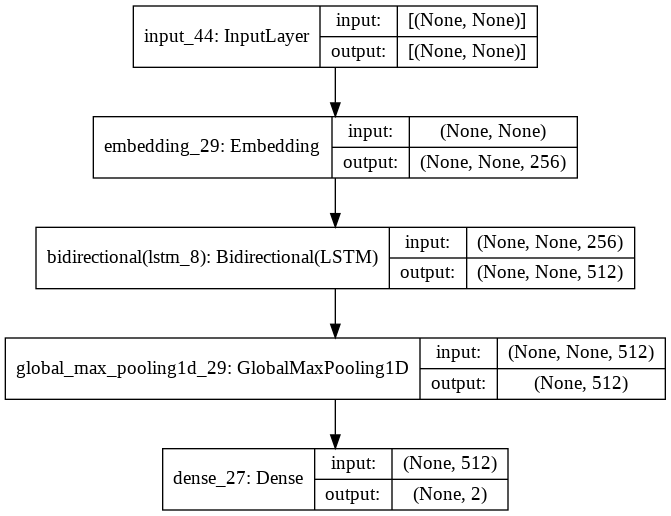

In [ ]:
model = build_model_type3(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.predict((train_inputs[:4]))

array([[0.49553224, 0.5044678 ],
       [0.49504706, 0.5049529 ],
       [0.49404913, 0.5059508 ],
       [0.49521264, 0.5047874 ]], dtype=float32)

In [ ]:
model.predict((test_inputs[:4]))

array([[0.49158123, 0.50841874],
       [0.4957178 , 0.5042822 ],
       [0.4919385 , 0.5080615 ],
       [0.49217165, 0.5078284 ]], dtype=float32)

## Train

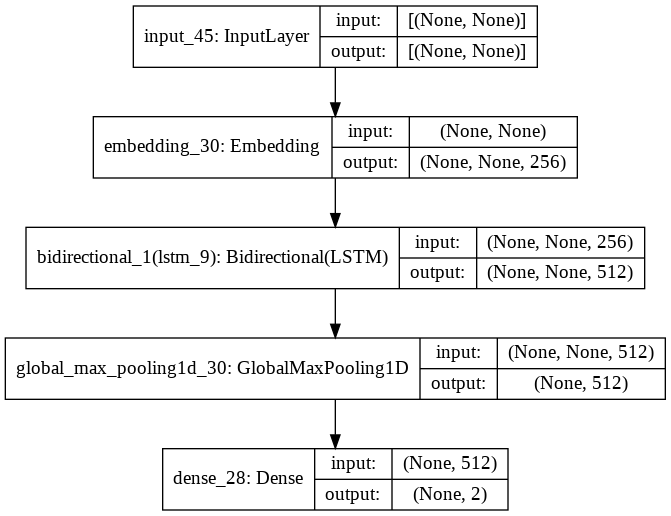

In [ ]:
model = build_model_type3(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(qp_dir, "type3.hdf5"),
                                                  monitor='val_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(qp_dir, "type3.csv"))

In [ ]:
history = model.fit(train_inputs, train_labels,
                    epochs=100,
                    batch_size=32,
                    validation_data=(test_inputs, test_labels),
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/100
216/216 [==============================] - 21s 87ms/step - loss: 0.5186 - accuracy: 0.7517 - val_loss: 0.9182 - val_accuracy: 0.5727

Epoch 00001: val_accuracy improved from -inf to 0.57267, saving model to /content/drive/MyDrive/Data/nlp/question_pair/type3.hdf5
Epoch 2/100
216/216 [==============================] - 18s 84ms/step - loss: 0.2847 - accuracy: 0.8846 - val_loss: 1.0322 - val_accuracy: 0.5828

Epoch 00002: val_accuracy improved from 0.57267 to 0.58285, saving model to /content/drive/MyDrive/Data/nlp/question_pair/type3.hdf5
Epoch 3/100
216/216 [==============================] - 18s 84ms/step - loss: 0.1925 - accuracy: 0.9267 - val_loss: 1.7005 - val_accuracy: 0.5756

Epoch 00003: val_accuracy did not improve from 0.58285
Epoch 4/100
216/216 [==============================] - 18s 84ms/step - loss: 0.1181 - accuracy: 0.9593 - val_loss: 1.6696 - val_accuracy: 0.5988

Epoch 00004: val_accuracy improved from 0.58285 to 0.59884, saving model to /content/drive/MyDrive

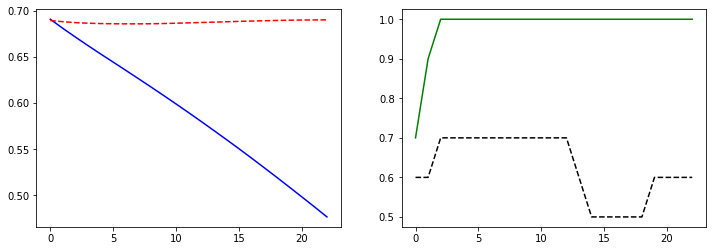

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')

plt.show()

## 평가

In [ ]:
model = build_model_type3(args)
model.load_weights(os.path.join(qp_dir, "type3.hdf5"))

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
model.evaluate(test_inputs, test_labels)

1/1 [==============================] - 0s 148ms/step - loss: 0.6870 - accuracy: 0.7000


[0.6869958639144897, 0.699999988079071]

In [ ]:
y_pred = model.predict(test_inputs)
y_pred

array([[0.506012  , 0.49398798],
       [0.50494784, 0.49505216],
       [0.51146024, 0.4885398 ],
       [0.5102867 , 0.4897133 ],
       [0.5008094 , 0.49919063],
       [0.5089402 , 0.49105975],
       [0.5078729 , 0.49212715],
       [0.5130322 , 0.48696783],
       [0.5109315 , 0.48906854],
       [0.51274484, 0.4872552 ]], dtype=float32)

In [ ]:
y_class = np.argmax(y_pred, axis=-1)
y_class

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
cf_matrix = np.zeros((2, 2)).astype(np.int)
cf_matrix

array([[0, 0],
       [0, 0]])

In [ ]:
for y_true, y_pred in zip(test_labels, y_class):
    cf_matrix[int(y_true), int(y_pred)] += 1
cf_matrix

array([[7, 0],
       [3, 0]])

In [ ]:
tp = cf_matrix[1, 1]
tn = cf_matrix[0, 0]
fp = cf_matrix[0, 1]
fn = cf_matrix[1, 0]

accuracy = (tp + tn) / max((tp + tn + fp + fn), 1)
print(f'accuracy: {accuracy}')
precision = (tp) / max((tp + fp), 1)
print(f'precision: {precision}')
recall = (tp) / max((tp + fn), 1)
print(f'recall: {recall}')
f1 = 2 * (precision * recall) / max((precision + recall), 1)
print(f'f1: {f1}')

accuracy: 0.7
precision: 0.0
recall: 0.0
f1: 0.0


## 배포

In [ ]:
model = build_model_type3(args)
model.load_weights(os.path.join(qp_dir, "type3.hdf5"))

In [ ]:
def do_predict(model, string1, string2):
    infer_input_1 = vocab.encode_as_ids(string1)
    infer_input_2 = vocab.encode_as_ids(string2)
    infer_input = infer_input_1 + [vocab.piece_to_id("[SEP]")] + infer_input_2
    infer_input = np.array([infer_input])

    y_pred = model.predict(infer_input)
    y_class = np.argmax(y_pred, axis=-1)[0]
    return id_to_label[y_class]

In [ ]:
while True:
    print("input 1> ", end="")
    string1 = str(input())
    if len(string1) == 0:
        break
    print("input 2> ", end="")
    string2 = str(input())
    if len(string2) == 0:
        break
    result = do_predict(model, string1, string2)
    print(result)

input 1> 엄청 심심해
input 2> 심심하다 심심해
다른 질문
input 1> 


# MaLSTM

## Train, Test 데이터 생성

In [ ]:
df_train = pd.read_csv('kor_pair_train.csv', delimiter=',')
df_train = df_train.dropna()
df_train

,id,qid1,qid2,question1,question2,is_duplicate
0,1,1,2,1000일 만난 여자친구와 이별,10년 연예의끝,1
1,2,3,4,10년 연애사 되돌아보니 다 부질없네,10년이라는 시간이 참 무색하다 싶네,1
2,3,5,6,10년만나다 헤어지네,14년된 여자친구랑 이별,1
3,4,7,8,10월의 마지막밤 . 더 보고싶네 그사람,15년…안녕,1
4,5,9,10,14년의 기나긴 이야기.,1년 9개월 의 연애 종지부.,1
...,...,...,...,...,...,...
6883,6884,13767,13768,O형 남자와 썸을 타는데,O형 여자와 썸을 타는데,1
6884,6885,13769,13770,SD카드 안돼,SD카드 망가졌어,0
6885,6886,13771,13772,SNS 를 끊어야 하는데.,가슴 아픈 이별,1
6886,6887,13773,13774,SNS 시간낭비인데 자꾸 보게됨,SNS 시간낭비인 거 아는데 매일 하는 중,0


In [ ]:
df_test = pd.read_csv('kor_Pair_test.csv', delimiter=',')
df_test = df_test[['test_id', 'question1', 'question2', 'is_duplicate']]
df_test = df_test.dropna()
df_test

,test_id,question1,question2,is_duplicate
0,1,21살의 사랑에 대해,사랑을 노력한다는게 말이 되나요?,1
1,2,2년 가량의 연애,2년 만났어,0
2,3,2년 만난 기념일이야,우리 벌써 2년 동안 사궜어,0
3,4,2년 사귀었는데 결혼하려고,2년째 짝사랑하는 사람이 있어.,1
4,5,5급면제도 나랑사랑카드 발급하나요?,아이콘 노래 사랑을 했다 별로인것같은데,1
...,...,...,...,...
683,684,회사에서 짤릴 필이 와,나 회사 짤릴 거 같은데 어떻게 만회하지,0
684,685,효율적으로 공부하는 방법,새 해 결심 뭐였더라,1
685,686,휴대폰 액정 깨졌어,액정 깨짐,0
686,687,힘든 일이 너무 많아요,괜찮아 천천히 해도 돼,1


In [ ]:
df_train['is_duplicate'].value_counts()
a = df_train.groupby('is_duplicate')
len(a)

2

In [ ]:
def oversample(df):
    n_max = df['is_duplicate'].value_counts().max()
    print(n_max)
    df_list = [df]
    for i_class, df_group in df.groupby('is_duplicate'): # groupby로 통해 0과 1 인 class로 바꿈
        print(i_class, len(df_group))
        df_list.append(df_group.sample(n_max - len(df_group), replace=True))
    df_new = pd.concat(df_list)
    return df_new

In [ ]:
def oversample(df):
    n_max = df['is_duplicate'].value_counts().max() # 안에 class중에 가장 data 수가 많은 class의 갯수
    print(n_max)
    df_list = [df]
    for i_class, df_group in df.groupby('is_duplicate'): # groupby로 통해 0과 1 인 class로 바꿈
        df_sample = df_group.sample(n_max - len(df_group), replace = True) # replace를 통해 중복 셈플을 허용할게 자기복제로 x 10 배한다는거지
        df_list.append(df_sample)
        print(i_class, len(df_group), len(df_sample))
    df_new = pd.concat(df_list) # list로 따로 떨어져있는 차원을 concat을 통해 뿥여줄게
    return df_new

In [ ]:
oversample(df_train)

# 한 라벨중 부족한 데이터 쪽을 뻠핑하는거야


4750
0 4750 0
1 2138 2612


,id,qid1,qid2,question1,question2,is_duplicate
0,1,1,2,1000일 만난 여자친구와 이별,10년 연예의끝,1
1,2,3,4,10년 연애사 되돌아보니 다 부질없네,10년이라는 시간이 참 무색하다 싶네,1
2,3,5,6,10년만나다 헤어지네,14년된 여자친구랑 이별,1
3,4,7,8,10월의 마지막밤 . 더 보고싶네 그사람,15년…안녕,1
4,5,9,10,14년의 기나긴 이야기.,1년 9개월 의 연애 종지부.,1
...,...,...,...,...,...,...
80,81,161,162,가슴 찢어지게 아파. 그 사람은 내 마음 알까?,가끔 짝남과 연애하는 상상을 해.,1
613,614,1227,1228,꿈이 너무 리얼하네,끈을 놓지 말자.,1
753,754,1507,1508,나라사랑카드 뭔가요?,나를 먼저 사랑해라 영어루,1
6658,6659,13317,13318,헤어진지 1년이면 재회는 힘들겠죠,헤어진지 1주일. 너무 힘드네.,1


In [ ]:
def undersample(df):
    n_min = df['is_duplicate'].value_counts().min()
    df_list = []
    for i_class, df_group in df.groupby('is_duplicate'):
        print(i_class, len(df_group))
        df_list.append(df_group.sample(n_min, replace=True))
    df_new = pd.concat(df_list)
    return df_new

In [ ]:
undersample(df_train)

0 4750
1 2138


,id,qid1,qid2,question1,question2,is_duplicate
5175,5176,10351,10352,전화를 너무 안 받아,연락이 너무 안돼,0
2375,2376,4751,4752,보통 좋아하는 애 생기면 먼저 연락해?,좋아하는 애 생기면 먼저 연락해도 돼?,0
4291,4292,8583,8584,완전 재미 없거든,재미 없어.,0
3434,3435,6869,6870,썸인지 헷갈려,썸인지 확인하는 방법 있나,0
1369,1370,2739,2740,누구에게나 친절한 남자 위험해?,누구에게나 친절한 남자 위험해?,0
...,...,...,...,...,...,...
4763,4764,9527,9528,이제 그만해야겠죠?,이제 너무 지쳐가네ㅠ,1
3500,3501,7001,7002,아무 것도 할 수 없는,아무리 기다려도 이젠 안돌아오나봐,1
3010,3011,6021,6022,술 먹고 짝남한테 카톡하는 거 좀 별로지.,이별 상태.,1
1023,1024,2047,2048,남자친구의 말 뜻,낭만이라고는 없어가지구,1


In [ ]:
def make_data(df, vocab, n_seq):
    inputs_1, inputs_2, labels = [], [], []

    for i, row in tqdm(df.iterrows(), total=len(df)):
        is_duplicate = 1 - row["is_duplicate"]  # 0 -> 1, 1 -> 0

        question1 = row["question1"]
        token1 = vocab.encode_as_ids(question1)[:n_seq]
        # token1 = token1 + [0] * (n_seq - len(token1)) # padding 뒤로 한 상태
        token1 =  [0] * (n_seq - len(token1)) + token1 # padding 앞으로 한 상태
        
        question2 = row["question2"]
        token2 = vocab.encode_as_ids(question2)[:n_seq]
        # token2 = token2 + [0] * (n_seq - len(token2)) # padding 뒤로 한 산태
        token2 = [0] * (n_seq - len(token2))  + token2 # padding 앞으로 한 상태

        assert len(token1) == n_seq
        assert len(token2) == n_seq

        inputs_1.append(token1)
        inputs_2.append(token2)
        labels.append(is_duplicate)

    inputs_1 = np.array(inputs_1)
    inputs_2 = np.array(inputs_2)
    labels = np.array(labels)
    return inputs_1, inputs_2, labels

In [ ]:

train_inputs_1, train_inputs_2, train_labels = make_data(df_train, vocab, 16) # make_data(undersample, vocab,16)
train_inputs_1, train_inputs_2, train_labels

(array([[    0,     0,     0, ...,    25,    31,  1009],
        [    0,     0,     0, ...,   507, 15358,   377],
        [    0,     0,     0, ...,  9250,    44,   377],
        ...,
        [    0,     0,     0, ...,   187,  2806,     7],
        [    0,     0,     0, ..., 11072, 12288,  4676],
        [    0,     0,     0, ..., 11614,  4431,   349]]),
 array([[    0,     0,     0, ..., 10200,     8, 12136],
        [    0,     0,     0, ...,    10, 31971,   377],
        [    0,     0,     0, ...,   828,    31,  1009],
        ...,
        [    0,     0,     0, ..., 11074,    31,  1009],
        [    0,     0,     0, ...,  4783,   228,    68],
        [    0,     0,     0, ...,  2364,  3030,     7]]),
 array([0, 0, 0, ..., 0, 1, 0]))

In [ ]:
train_inputs_1.shape, train_inputs_2.shape, train_labels.shape

((6888, 16), (6888, 16), (6888,))

In [ ]:
test_inputs_1, test_inputs_2, test_labels = make_data(df_test, vocab, 16)
test_inputs_1, test_inputs_2, test_labels

(array([[    0,     0,     0, ..., 12785, 15185,   363],
        [    0,     0,     0, ...,  5960,     8,  7479],
        [    0,     0,     0, ...,    30,    20,   187],
        ...,
        [    0,     0,     0, ...,  5563, 10540,   107],
        [    0,     0,     0, ...,  2364,  5262,   506],
        [    0,     0,     0, ...,  6726,    57,  2138]]),
 array([[    0,     0,     0, ...,    57,   506,  2138],
        [    0,     0,     0, ...,    17, 13297,   107],
        [    0,     0,     0, ...,   227, 31560,   107],
        ...,
        [    0,     0,     0, ..., 26008,  5563,  5394],
        [    0,     0,     0, ...,   127,  4401, 10091],
        [    0,     0,     0, ...,  1618,  1695, 14506]]),
 array([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0,
        0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
test_inputs_1.shape, test_inputs_2.shape, test_labels.shape

((688, 16), (688, 16), (688,))

## Modeling

In [ ]:
args.n_vocab = len(vocab)
args.d_model = 256
args.n_out = 2
args.ckpoint = os.path.join(qp_dir, 'malstm.hdf5')
args.csv = os.path.join(qp_dir, 'malstm.csv')
args

# 보통은 이렇게 많이 함

Namespace(d_model=256, n_out=2, n_vocab=32007, seed=1234)

In [ ]:
hidden_1 = np.random.rand(2,4)
hidden_2 = np.random.rand(2,4)

hidden_1, hidden_2

(array([[0.79052413, 0.99208147, 0.95880176, 0.79196414],
        [0.28525096, 0.62491671, 0.4780938 , 0.19567518]]),
 array([[0.38231745, 0.05387369, 0.45164841, 0.98200474],
        [0.1239427 , 0.1193809 , 0.73852306, 0.58730363]]))

In [ ]:
hidden_1 - hidden_2

array([[ 0.40820668,  0.93820778,  0.50715335, -0.19004061],
       [ 0.16130826,  0.50553581, -0.26042926, -0.39162845]])

In [ ]:
K.abs(hidden_1 - hidden_2)
K.sum(K.abs(hidden_1 - hidden_2), axis = -1) # 가로축을 다 더하는거니까
# K.sum(K.abs(hidden_1 - hidden_2)) # numpy를 쓰게 되면 error 남 ,

# tf로 쓰면 가끔 에러남
# K.로 씀


<tf.Tensor: shape=(2,), dtype=float64, numpy=array([2.04360842, 1.31890178])>

In [ ]:
def build_model_malstm(args):
    inputs_1 = tf.keras.layers.Input((None,)) #(bs,n_seq1)
    inputs_2 = tf.keras.layers.Input((None,)) #(bs,n_seq2)

    embedding = tf.keras.layers.Embedding(args.n_vocab, args.d_model) 
    hidden_1 = embedding(inputs_1) # (batch_size, seq1 ,d_model)
    hidden_2 = embedding(inputs_2) # embedding 통과 # (batch_size, seq2 ,d_model)

    lstm = tf.keras.layers.LSTM(units=args.d_model, go_backwards=False) # 앞으로부터 학습함
    hidden_1 = lstm(hidden_1) # 마지막 hidden만 썼으니까 마지막 node값만 = return_sequence = False -> (batch_size, unit)
    hidden_2 = lstm(hidden_2) # (batch_size, unit)

    # distance 계산 ||a - b||
    distance = K.sum(K.abs(hidden_1 - hidden_2), axis=-1) # 빼고 절댓값에다가 exp 올려야지
                                                        # la-bl
                                                        # K는 backend library임
    y_pred = K.exp(-distance)

    model = tf.keras.Model(inputs=(inputs_1, inputs_2), outputs=y_pred)
    return model

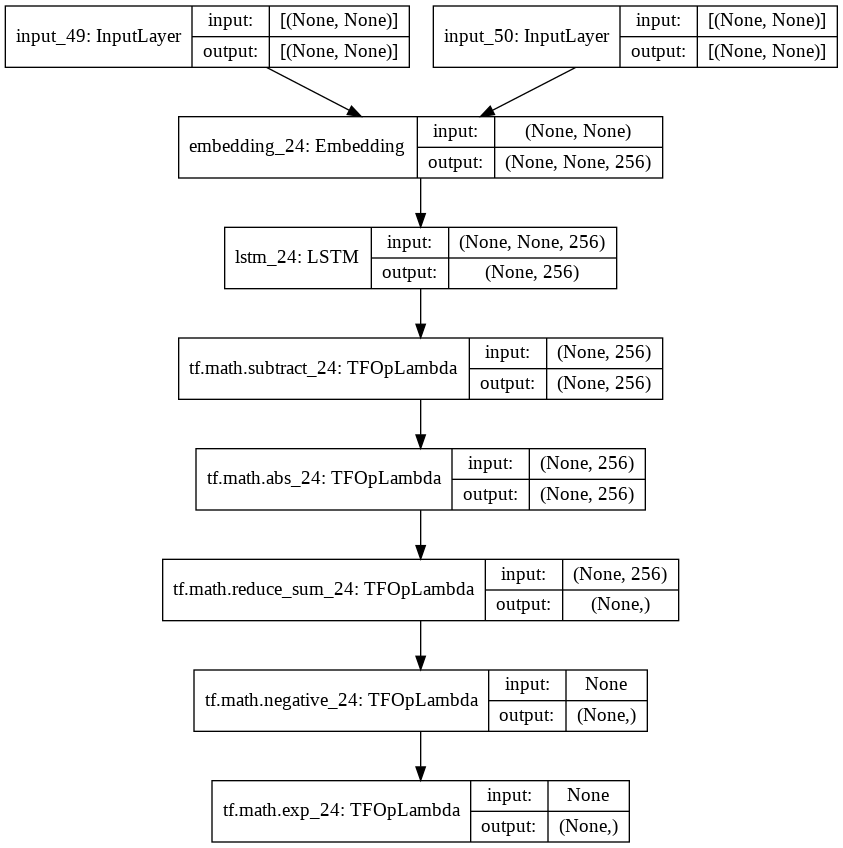

In [ ]:
model = build_model_malstm(args)
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:

model.predict((train_inputs_1[:4], train_inputs_2[:4]))

# 1에 가까운거면 비슷한거고
# 0에 가까운거면 먼거고

array([0.16151538, 0.23160051, 0.11752581, 0.08953301], dtype=float32)

In [ ]:
model.predict((test_inputs_1[:4], test_inputs_2[:4]))

array([0.10415107, 0.21422988, 0.15154359, 0.12555496], dtype=float32)

## Train

In [ ]:
model = build_model_malstm(args)
# tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["binary_accuracy"])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=10)
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(qp_dir, "malstm.hdf5"),
                                                  monitor='val_binary_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(qp_dir, "malstm.csv"))

In [ ]:
history = model.fit((train_inputs_1, train_inputs_2), train_labels,
                    epochs=50,
                    batch_size=128,
                    validation_data=((test_inputs_1, test_inputs_2), test_labels),
                    callbacks=[early_stopping, save_weights, csv_logger])
                    # class_weight={0: 2, 1: 1})

Epoch 1/50
54/54 [==============================] - 8s 97ms/step - loss: 0.2294 - binary_accuracy: 0.6325 - val_loss: 0.2393 - val_binary_accuracy: 0.5720

Epoch 00001: val_binary_accuracy improved from -inf to 0.57205, saving model to /content/drive/MyDrive/ict-ai-복합고급언어-nlp/data/question_pair/malstm.hdf5
Epoch 2/50
54/54 [==============================] - 5s 84ms/step - loss: 0.1078 - binary_accuracy: 0.8824 - val_loss: 0.2196 - val_binary_accuracy: 0.6458

Epoch 00002: val_binary_accuracy improved from 0.57205 to 0.64583, saving model to /content/drive/MyDrive/ict-ai-복합고급언어-nlp/data/question_pair/malstm.hdf5
Epoch 3/50
54/54 [==============================] - 5s 85ms/step - loss: 0.0787 - binary_accuracy: 0.9548 - val_loss: 0.2085 - val_binary_accuracy: 0.6675

Epoch 00003: val_binary_accuracy improved from 0.64583 to 0.66753, saving model to /content/drive/MyDrive/ict-ai-복합고급언어-nlp/data/question_pair/malstm.hdf5
Epoch 4/50
54/54 [======================

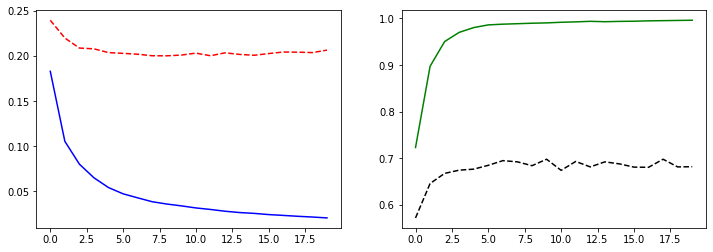

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['binary_accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_binary_accuracy'], 'k--', label='val_accuracy')

plt.show()

## 평가

In [ ]:
model = build_model_malstm(args)
model.load_weights(os.path.join(qp_dir, "malstm.hdf5"))

In [ ]:
model.compile(loss="mean_squared_error", optimizer="adam", metrics=["binary_accuracy"])

In [ ]:
model.evaluate((test_inputs_1, test_inputs_2), test_labels)

22/22 [==============================] - 1s 5ms/step - loss: 0.1998 - binary_accuracy: 0.7129


[0.20079468190670013, 0.6974431872367859]

In [ ]:
y_pred = model.predict((test_inputs_1, test_inputs_2))
y_pred

array([0.39204833, 0.28523666, 0.62174535, 0.3012358 , 0.17669304,
       0.09393676, 0.5057593 , 0.49903786, 0.6855487 , 0.56832534,
       0.45646846, 0.47813594, 0.43349501, 0.3016853 , 0.1821523 ,
       0.7691024 , 0.58730733, 0.6580926 , 0.5846738 , 0.75642693,
       0.20636536, 0.5271948 , 0.81183416, 0.65829206, 0.6379625 ,
       0.4251631 , 0.3049568 , 0.735817  , 0.6057462 , 0.93772674,
       0.3021093 , 0.4059344 , 0.22090106, 0.690741  , 0.7191272 ,
       0.5690984 , 0.4637047 , 0.3276776 , 0.6330099 , 0.8546735 ,
       0.4629491 , 0.3368412 , 0.25950328, 0.56379485, 0.05195047,
       0.9247509 , 0.57684773, 1.        , 0.70840526, 0.37675887,
       0.5509394 , 0.5995171 , 0.18446565, 0.74708223, 0.51987755,
       0.63553613, 0.73142767, 0.48762688, 0.606736  , 0.75882816,
       0.62600166, 0.6942155 , 0.6985398 , 0.5600375 , 0.5234749 ,
       0.53307766, 0.3984172 , 0.20531285, 0.69395685, 0.33358893,
       0.43537146, 0.569829  , 1.        , 0.747288  , 0.67806

In [ ]:
y_class = (y_pred > 0.5).astype(np.int)
y_class

array([0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,

In [ ]:
cf_matrix = np.zeros((2, 2)).astype(np.int)
cf_matrix

array([[0, 0],
       [0, 0]])

In [ ]:
for y_true, y_pred in zip(test_labels, y_class):
    cf_matrix[int(y_true), int(y_pred)] += 1
cf_matrix

array([[198, 131],
       [ 76, 283]])

In [ ]:
tp = cf_matrix[1, 1]
tn = cf_matrix[0, 0]
fp = cf_matrix[0, 1]
fn = cf_matrix[1, 0]

accuracy = (tp + tn) / max((tp + tn + fp + fn), 1)
print(f'accuracy: {accuracy}')
precision = (tp) / max((tp + fp), 1)
print(f'precision: {precision}')
recall = (tp) / max((tp + fn), 1)
print(f'recall: {recall}')
f1 = 2 * (precision * recall) / max((precision + recall), 1)
print(f'f1: {f1}')

accuracy: 0.6991279069767442
precision: 0.6835748792270532
recall: 0.7883008356545961
f1: 0.7322121604139715


## 배포

In [ ]:
model = build_model_malstm(args)
model.load_weights(os.path.join(qp_dir, "malstm.hdf5"))

In [ ]:
def do_predict(model, string1, string2):
    infer_input_1 = vocab.encode_as_ids(string1)
    infer_input_1 = np.array([infer_input_1])

    infer_input_2 = vocab.encode_as_ids(string2)
    infer_input_2 = np.array([infer_input_2])

    y_pred = model.predict((infer_input_1, infer_input_2))
    y_class = (y_pred > 0.5)[0]
    y_class = 1 if y_class else 0
    return id_to_label[y_class]

In [ ]:
while True:
    print("input 1> ", end="")
    string1 = str(input())
    if len(string1) == 0:
        break
    print("input 2> ", end="")
    string2 = str(input())
    if len(string2) == 0:
        break
    result = do_predict(model, string1, string2)
    print(result)

input 1> 
